In [ ]:
# lets import necessary libraries
import numpy as numpy
import pandas as pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from datetime import datetime, timedelta
import os

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import unicodedata
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [20]:
# lets load the dataset
import pandas as pd
df = pd.read_csv("task_management_dataset_5k_enhanced..csv")

In [21]:
df.head()

,task_id,description,category,priority,status,assigned_to,department,complexity,estimated_hours,created_date,due_date,urgency,tags
0,TASK-00001,EMERGENCY: Prepare data dictionary with Readme...,Documentation,Critical,To Do,Lisa Wang,Quality Assurance,10,6,2025-11-20,2025-11-26,1,"wiki, technical-writing, hotfix"
1,TASK-00002,PLANNED: Compose troubleshooting documentation...,Documentation,Medium,In Review,Jessica Brown,Product,3,8,2025-10-01,2025-12-05,0,"guide, technical-writing, planned"
2,TASK-00003,"Configure webhook handler with Apache Kafka, i...",Development,Low,To Do,David Wilson,Engineering,4,5,2025-11-14,2026-01-09,0,"feature, api, tech-debt"
3,TASK-00004,"Create data dictionary with Markdown format, i...",Documentation,Low,In Progress,Jessica Brown,Product,2,1,2025-10-28,2025-12-19,0,"guide, wiki, nice-to-have"
4,TASK-00005,SCHEDULED: Update load testing with Cucumber B...,Testing,Medium,In Review,Christopher Lee,Engineering,5,7,2025-10-08,2025-12-08,0,"regression, qa, planned"


In [22]:
df.info

<bound method DataFrame.info of          task_id                                        description  \
0     TASK-00001  EMERGENCY: Prepare data dictionary with Readme...   
1     TASK-00002  PLANNED: Compose troubleshooting documentation...   
2     TASK-00003  Configure webhook handler with Apache Kafka, i...   
3     TASK-00004  Create data dictionary with Markdown format, i...   
4     TASK-00005  SCHEDULED: Update load testing with Cucumber B...   
...          ...                                                ...   
4995  TASK-04996  Develop audit logging service with Apache Kafk...   
4996  TASK-04997  BACKLOG: Prototype industry compliance require...   
4997  TASK-04998  TIME-SENSITIVE: Carry out load testing with Pl...   
4998  TASK-04999  WHEN POSSIBLE: Explore new technology stack op...   
4999  TASK-05000  PLANNED: Set up recommendation algorithm with ...   

           category  priority       status      assigned_to  \
0     Documentation  Critical        To Do        Li

In [23]:
df.describe()

,complexity,estimated_hours,urgency
count,5000.000000,5000.000000,5000.000000
mean,5.318200,5.928800,0.414000
std,2.189682,3.141672,0.492598
min,1.000000,1.000000,0.000000
25%,4.000000,4.000000,0.000000
50%,5.000000,6.000000,0.000000
75%,7.000000,8.000000,1.000000
max,10.000000,16.000000,1.000000


## Data Preprocessing

In [24]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [25]:
# lets check for missing values
missing = df.isnull().sum().sum()
print(f" Missing values: {missing}")

 Missing values: 0


In [26]:
# lets check for duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f" Removed {duplicates} duplicates")
else:
    print(f" No duplicates found")

 No duplicates found


In [27]:
#Covert datatypes
df['created_date'] = pd.to_datetime(df['created_date'])
df['due_date'] = pd.to_datetime(df['due_date'])

In [28]:
# Categorical columns
for col in ['category', 'priority', 'status', 'department']:
    df[col] = df[col].astype('category')

In [29]:
# validate and fix dates
invalid_dates = df[df['due_date'] < df['created_date']]
if len(invalid_dates) > 0:
    mask = df['due_date'] < df['created_date']
    df.loc[mask, 'due_date'] = df.loc[mask, 'created_date'] + pd.Timedelta(days=7)
    print(f" Fixed {len(invalid_dates)} invalid dates")
else:
    print(" All dates valid")

 All dates valid


In [30]:
# lets create derived features
df['days_until_due'] = (df['due_date'] - pd.Timestamp.now()).dt.days
df['task_age_days'] = (pd.Timestamp.now() - df['created_date']).dt.days

In [31]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'^(urgent|critical|emergency|blocker|p0|p1|p2|p3|immediate action required|production issue|severity 1|high priority|important|time-sensitive|deadline approaching|client request|release blocker|standard|planned|scheduled|backlog|nice to have|when possible|low priority|future|optional|improvement|outage|incident|hotfix needed|sprint goal|committed|escalated):\s*', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['description_cleaned'] = df['description'].apply(clean_text)

In [32]:
# text preprocessing
stop_words = set(stopwords.words('english'))
custom_stop_words = {'using', 'ensure', 'ensuring', 'follow', 'following', 
                     'include', 'including', 'need', 'needs', 'needed', 
                     'please', 'task', 'tasks', 'complete', 'completed', 
                     'update', 'updated', 'also', 'well'}
stop_words = stop_words.union(custom_stop_words)
lemmatizer = WordNetLemmatizer()

def preprocess_text_advanced(text):
    if pd.isna(text) or text == '':
        return ""
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['description_processed'] = df['description_cleaned'].apply(preprocess_text_advanced)

In [33]:
final_columns = [
    'task_id',
    'description',
    'description_processed',
    'category',
    'priority',
    'status',
    'assigned_to',
    'department',
    'complexity',
    'estimated_hours',
    'urgency',
    'due_date'
]

df_final = df[final_columns].copy()

# Save
df_final.to_csv('task_management_cleaned.csv', index=False)

## exploratory data analysis

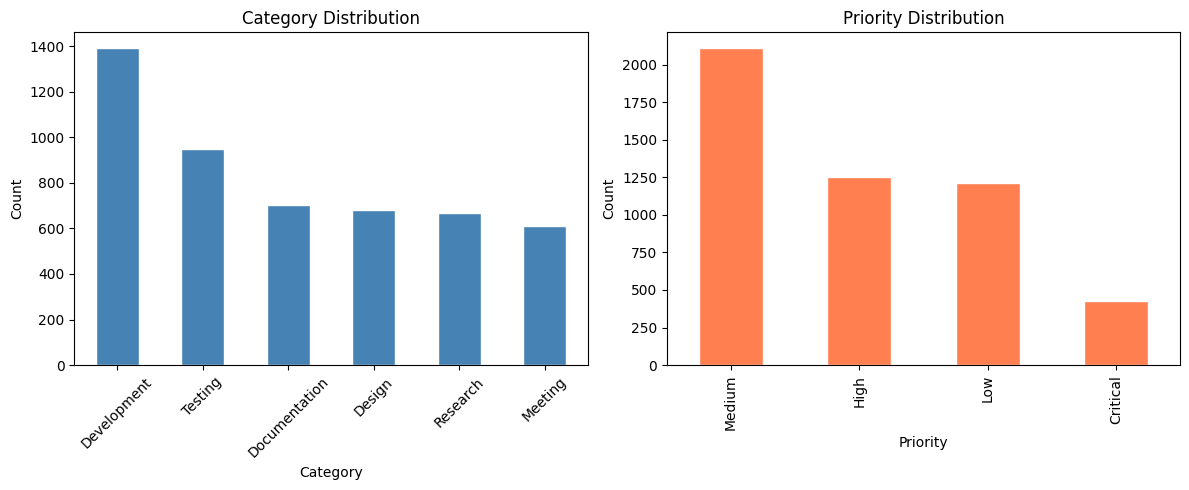

In [ ]:
# target distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['category'].value_counts().plot(kind='bar', color='steelblue', edgecolor='white')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df['priority'].value_counts().plot(kind='bar', color='coral', edgecolor='white')
plt.title('Priority Distribution')
plt.xlabel('Priority')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
num_cols = df.select_dtypes(include=np.number).columns.tolist()

print("Numeric Columns:", num_cols)

Numeric Columns: ['complexity', 'estimated_hours', 'urgency']


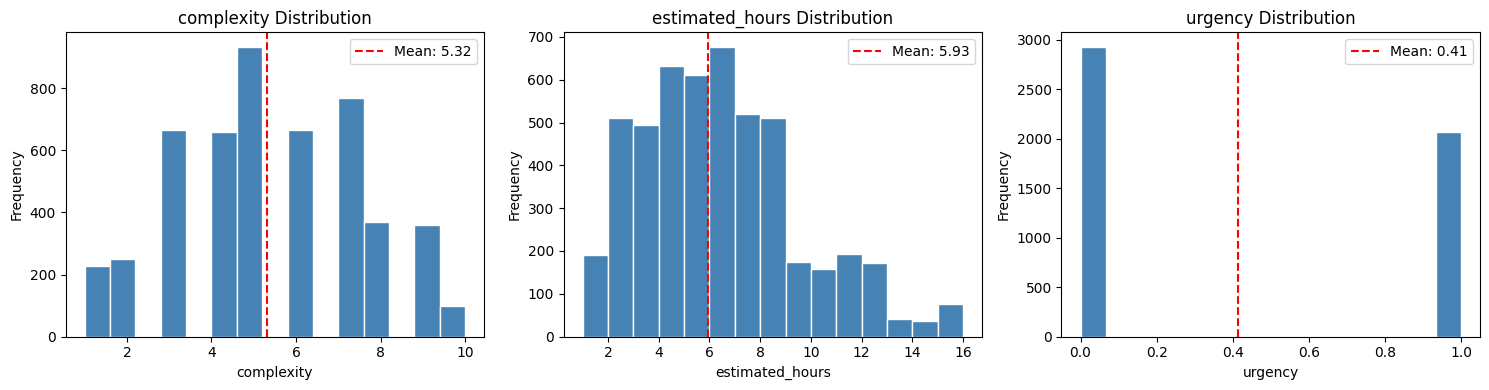

In [ ]:
# numerical distribution
plt.figure(figsize=(15, 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    plt.hist(df[col], bins=15, color='steelblue', edgecolor='white')
    plt.axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.2f}')
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

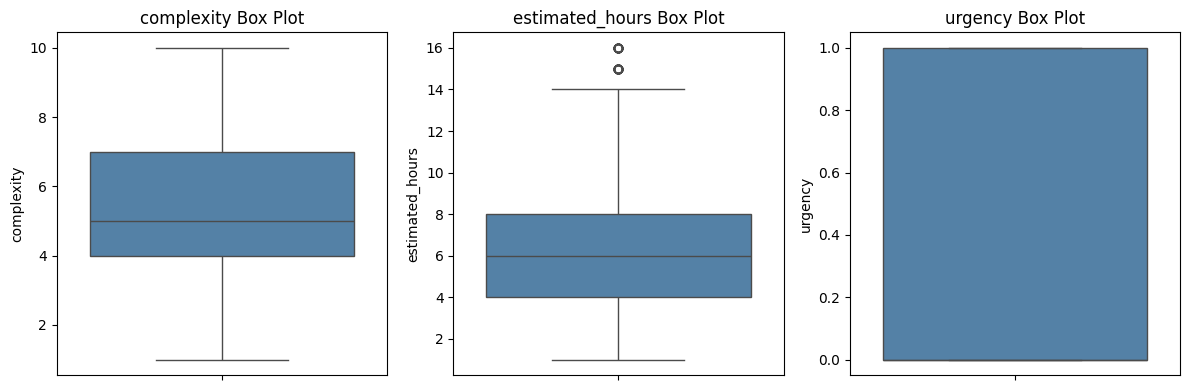

In [ ]:
# box plots
plt.figure(figsize=(12, 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col], color='steelblue')
    plt.title(f'{col} Box Plot')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

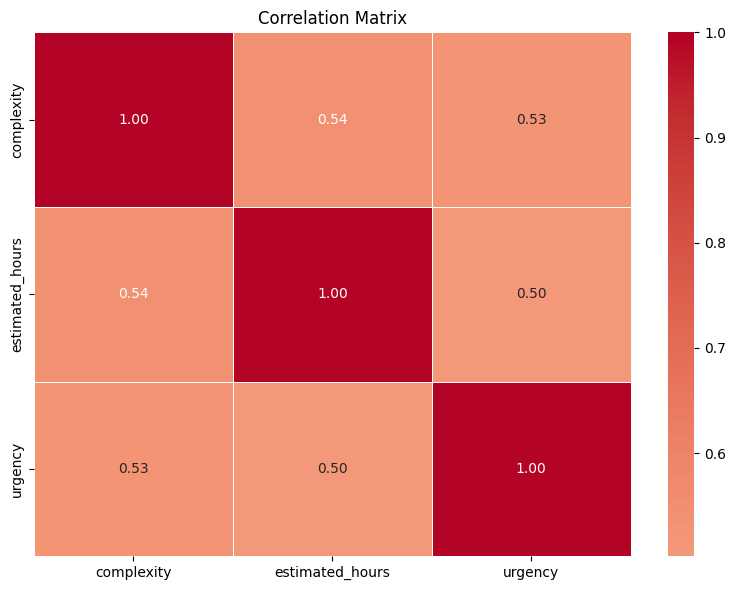


Correlation Matrix:
                 complexity  estimated_hours  urgency
complexity            1.000            0.544    0.528
estimated_hours       0.544            1.000    0.502
urgency               0.528            0.502    1.000


In [ ]:
# co-relation matrix
corr = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(corr.round(3))

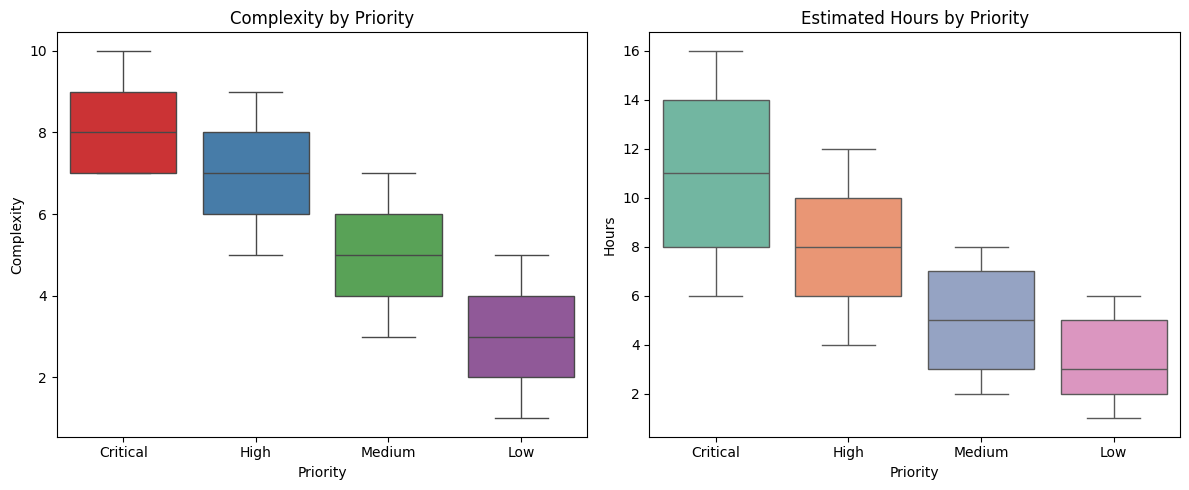


Mean by Priority:
          complexity  estimated_hours  urgency
priority                                      
Critical        8.40            10.94     1.00
High            7.02             8.00     0.85
Low             3.02             3.51     0.04
Medium          5.00             5.07     0.25


In [ ]:
#  TARGET vs FEATURES 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='priority', y='complexity', 
            order=['Critical', 'High', 'Medium', 'Low'], palette='Set1')
plt.title('Complexity by Priority')
plt.xlabel('Priority')
plt.ylabel('Complexity')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='priority', y='estimated_hours',
            order=['Critical', 'High', 'Medium', 'Low'], palette='Set2')
plt.title('Estimated Hours by Priority')
plt.xlabel('Priority')
plt.ylabel('Hours')

plt.tight_layout()
plt.show()

# Mean values
print("\nMean by Priority:")
print(df.groupby('priority')[num_cols].mean().round(2))

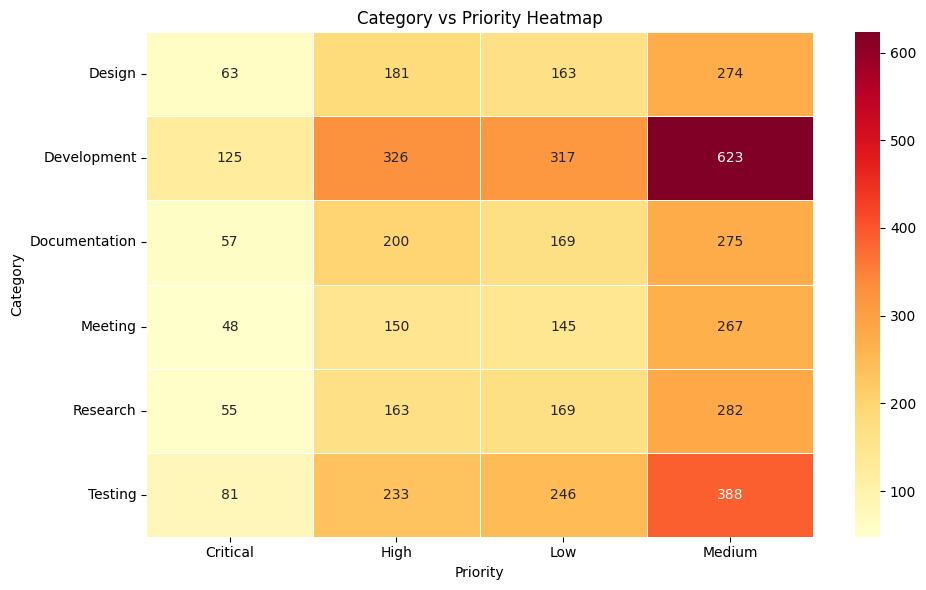

In [ ]:
# category vs priority
cross_tab = pd.crosstab(df['category'], df['priority'])

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd', linewidths=0.5)
plt.title('Category vs Priority Heatmap')
plt.xlabel('Priority')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

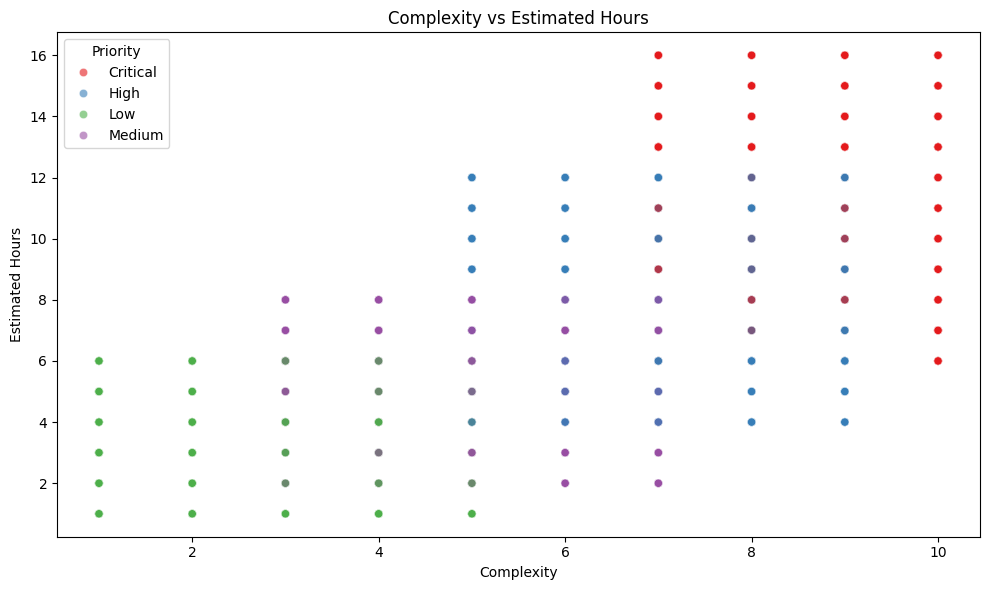

In [ ]:
#  Complexity vs Hours
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='complexity', y='estimated_hours', hue='priority',
                palette='Set1', alpha=0.6)
plt.title('Complexity vs Estimated Hours')
plt.xlabel('Complexity')
plt.ylabel('Estimated Hours')
plt.legend(title='Priority')
plt.tight_layout()
plt.show()

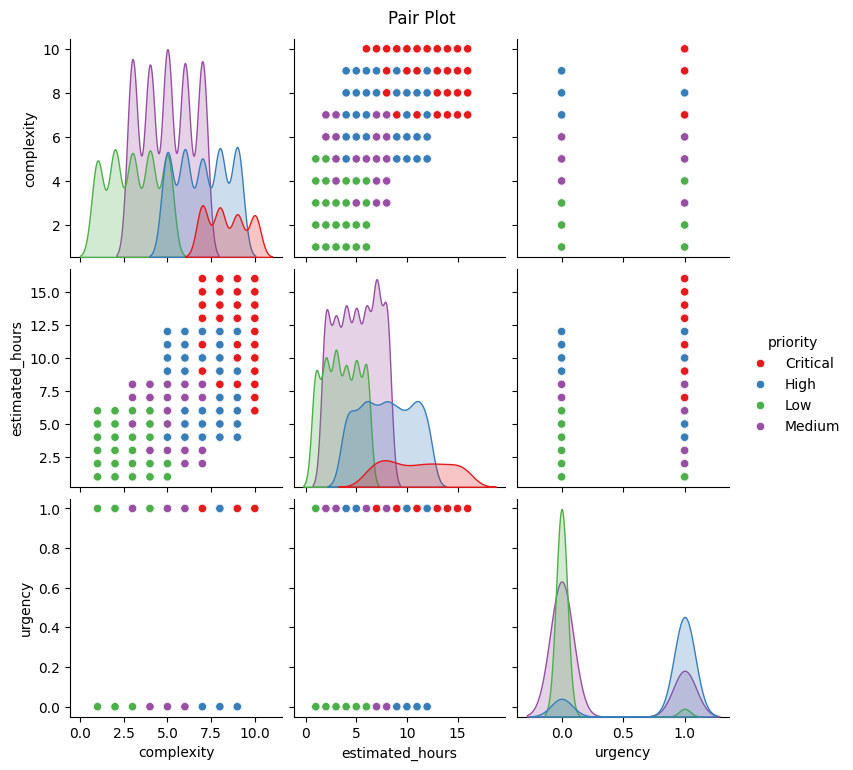

In [ ]:
sns.pairplot(df[num_cols + ['priority']], hue='priority', palette='Set1')
plt.suptitle('Pair Plot', y=1.02)
plt.show()

In [ ]:
df.select_dtypes(include='object').columns


Index(['task_id', 'description', 'assigned_to', 'tags', 'description_cleaned',
       'description_processed'],
      dtype='object')

In [ ]:
from wordcloud import WordCloud
text_col = 'description'

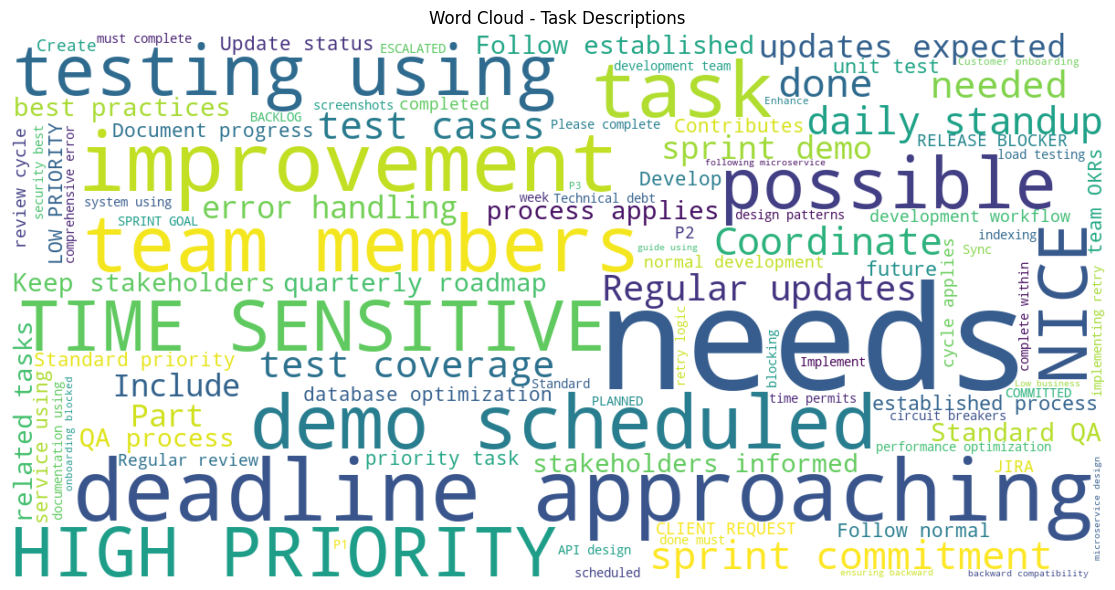

In [ ]:
#  task description using word clouds
all_text = ' '.join(df[text_col].dropna().astype(str))

plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=1200, height=600, background_color='white',
                      colormap='viridis', max_words=100).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Task Descriptions')
plt.tight_layout()
plt.show()

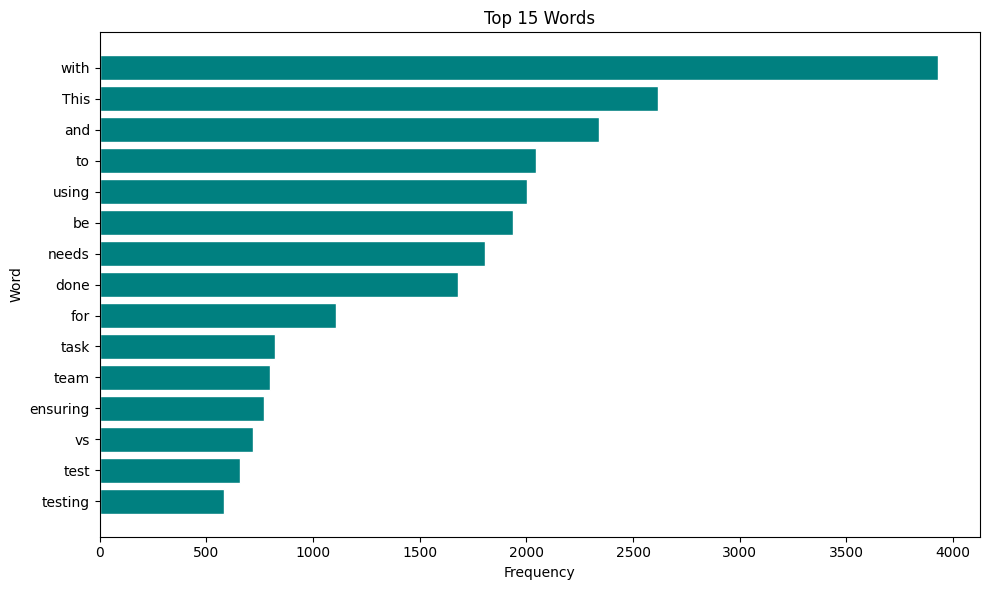

In [ ]:
# frequent words
from collections import Counter
words = all_text.split()
word_freq = Counter(words).most_common(15)
words_list, counts_list = zip(*word_freq)

plt.figure(figsize=(10, 6))
plt.barh(words_list, counts_list, color='teal', edgecolor='white')
plt.gca().invert_yaxis()
plt.title('Top 15 Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

## Feature extraction using TF-IDF and text classification

In [ ]:
# Load original dataset
df = pd.read_csv('task_management_dataset_5k_enhanced..csv')
df['description'] = df['description'].fillna('').astype(str)

print(f"Original size: {len(df)}")

# noise injecting
np.random.seed(42)
noise_percentage = 0.10 
n_to_flip = int(len(df) * noise_percentage)
flip_indices = np.random.choice(df.index, size=n_to_flip, replace=False)

# Get all categories
categories = df['category'].unique().tolist()

# Flip labels 
for idx in flip_indices:
    current_cat = df.loc[idx, 'category']
    other_cats = [c for c in categories if c != current_cat]
    df.loc[idx, 'category'] = np.random.choice(other_cats)

print(f"Mislabeled {n_to_flip} samples ({noise_percentage*100:.0f}%)")

Original size: 5000
Mislabeled 500 samples (10%)


In [39]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    df['description'],  # Using 'description' column
    df['category'],
    test_size=0.25,
    random_state=42,
    stratify=df['category']
)

# TF-IDF
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2), min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_pred = nb.predict(X_test_tfidf)

# SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_tfidf, y_train)
svm_pred = svm.predict(X_test_tfidf)

In [40]:
# Results
print(f"\nNaive Bayes Accuracy: {accuracy_score(y_test, nb_pred):.2%}")
print(f"SVM Accuracy:         {accuracy_score(y_test, svm_pred):.2%}")

print("\n--- Naive Bayes Classification Report ---")
print(classification_report(y_test, nb_pred))

print("\n--- SVM Classification Report ---")
print(classification_report(y_test, svm_pred))


Naive Bayes Accuracy: 88.64%
SVM Accuracy:         89.68%

--- Naive Bayes Classification Report ---
               precision    recall  f1-score   support

       Design       0.92      0.84      0.88       173
  Development       0.90      0.93      0.91       335
Documentation       0.86      0.88      0.87       177
      Meeting       0.87      0.89      0.88       160
     Research       0.91      0.87      0.89       176
      Testing       0.87      0.88      0.88       229

     accuracy                           0.89      1250
    macro avg       0.89      0.88      0.88      1250
 weighted avg       0.89      0.89      0.89      1250


--- SVM Classification Report ---
               precision    recall  f1-score   support

       Design       0.92      0.88      0.90       173
  Development       0.91      0.93      0.92       335
Documentation       0.88      0.89      0.89       177
      Meeting       0.88      0.89      0.89       160
     Research       0.91      0.87

In [ ]:
# Save models
joblib.dump(nb, 'naive_bayes_model.pkl')
joblib.dump(svm, 'svm_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(categories, 'category_labels.pkl')

['category_labels.pkl']

## Priority prediction Using Randomforest and XG boost

In [ ]:
df = pd.read_csv('task_management_dataset_5k_enhanced..csv')

print(f"Original size: {len(df)}")
print(f"\nOriginal Priority Distribution:")
print(df['priority'].value_counts())

# noise injecting
np.random.seed(123)

noise_pct = 0.10
n_flip = int(len(df) * noise_pct)
flip_idx = np.random.choice(df.index, size=n_flip, replace=False)

priorities = ['Low', 'Medium', 'High', 'Critical']

for idx in flip_idx:
    current = df.loc[idx, 'priority']
    others = [p for p in priorities if p != current]
    df.loc[idx, 'priority'] = np.random.choice(others)

print(f"\n Mislabeled {n_flip} priority labels ({noise_pct*100:.0f}%)")

df.to_csv('priority_dataset_10pct_noise.csv', index=False)
print(f"\n Saved: priority_dataset_10pct_noise.csv")
print(f"\nNew Priority Distribution:")
print(df['priority'].value_counts())

Original size: 5000

Original Priority Distribution:
priority
Medium      2109
High        1253
Low         1209
Critical     429
Name: count, dtype: int64

 Mislabeled 500 priority labels (10%)

 Saved: priority_dataset_10pct_noise.csv

New Priority Distribution:
priority
Medium      2019
High        1257
Low         1181
Critical     543
Name: count, dtype: int64


In [ ]:
pip install xgboost

In [ ]:
df = pd.read_csv('priority_dataset_10pct_noise.csv')
print(f"Dataset shape: {df.shape}")

# feature engineering
df_encoded = df.copy()
label_encoders = {}

categorical_cols = ['category', 'status', 'department', 'assigned_to']

for col in categorical_cols:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

# Encode priority
priority_order = ['Low', 'Medium', 'High', 'Critical']
priority_encoder = LabelEncoder()
priority_encoder.fit(priority_order)
df_encoded['priority_encoded'] = priority_encoder.transform(df_encoded['priority'])

# Text features
df_encoded['desc_length'] = df_encoded['description'].fillna('').str.len()
df_encoded['word_count'] = df_encoded['description'].fillna('').str.split().str.len()

Dataset shape: (5000, 13)


In [ ]:
# select features
potential_features = [
    'complexity', 'estimated_hours', 'urgency',
    'category_encoded', 'status_encoded', 'department_encoded',
    'desc_length', 'word_count'
]

feature_cols = [col for col in potential_features if col in df_encoded.columns]
print(f"\nFeatures: {feature_cols}")

X = df_encoded[feature_cols].fillna(0)
y = df_encoded['priority_encoded']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training: {len(X_train)} | Testing: {len(X_test)}")

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Features: ['complexity', 'estimated_hours', 'urgency', 'category_encoded', 'status_encoded', 'department_encoded', 'desc_length', 'word_count']
Training: 3750 | Testing: 1250


In [ ]:
# random forest classifier
rf_baseline = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_scaled, y_train)
rf_pred = rf_baseline.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_pred)

print(f"Accuracy: {rf_acc:.4f} ({rf_acc*100:.2f}%)")
print(classification_report(y_test, rf_pred, target_names=priority_encoder.classes_))

# xg boost classifier
xgb_baseline = XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False)
xgb_baseline.fit(X_train_scaled, y_train)
xgb_pred = xgb_baseline.predict(X_test_scaled)
xgb_acc = accuracy_score(y_test, xgb_pred)

Accuracy: 0.7536 (75.36%)
              precision    recall  f1-score   support

    Critical       0.80      0.42      0.55       136
        High       0.76      0.89      0.82       314
         Low       0.67      0.67      0.67       295
      Medium       0.79      0.81      0.80       505

    accuracy                           0.75      1250
   macro avg       0.76      0.70      0.71      1250
weighted avg       0.76      0.75      0.75      1250



In [ ]:
print(f"Accuracy: {xgb_acc:.4f} ({xgb_acc*100:.2f}%)")
print(classification_report(y_test, xgb_pred, target_names=priority_encoder.classes_))

print(f"Random Forest: {rf_acc*100:.2f}%")
print(f"XGBoost:       {xgb_acc*100:.2f}%")

Accuracy: 0.7624 (76.24%)
              precision    recall  f1-score   support

    Critical       0.79      0.44      0.57       136
        High       0.77      0.89      0.82       314
         Low       0.68      0.69      0.68       295
      Medium       0.80      0.82      0.81       505

    accuracy                           0.76      1250
   macro avg       0.76      0.71      0.72      1250
weighted avg       0.76      0.76      0.76      1250

Random Forest: 75.36%
XGBoost:       76.24%


In [ ]:
# hyperparameter grid  for random forest using Gridsearchcv
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Training Random Forest")
rf_grid.fit(X_train_scaled, y_train)

Training Random Forest
Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [ ]:
print(f"\n Best Parameters: {rf_grid.best_params_}")
print(f"Best CV Score: {rf_grid.best_score_:.4f} ({rf_grid.best_score_*100:.2f}%)")

rf_tuned_pred = rf_grid.predict(X_test_scaled)
rf_tuned_acc = accuracy_score(y_test, rf_tuned_pred)
print(f"Test Accuracy: {rf_tuned_acc:.4f} ({rf_tuned_acc*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(y_test, rf_tuned_pred, target_names=priority_encoder.classes_))


 Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best CV Score: 0.7648 (76.48%)
Test Accuracy: 0.7616 (76.16%)

Classification Report:
              precision    recall  f1-score   support

    Critical       0.88      0.38      0.53       136
        High       0.75      0.91      0.82       314
         Low       0.73      0.60      0.66       295
      Medium       0.77      0.87      0.82       505

    accuracy                           0.76      1250
   macro avg       0.78      0.69      0.71      1250
weighted avg       0.77      0.76      0.75      1250



In [ ]:
 # hyperparameter grid  for xg boost using Gridsearchcv
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False),
    param_grid=xgb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Training XGBoost")
xgb_grid.fit(X_train_scaled, y_train)

Training XGBoost
Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [ ]:
print(f"\n Best Parameters: {xgb_grid.best_params_}")
print(f"Best CV Score: {xgb_grid.best_score_:.4f} ({xgb_grid.best_score_*100:.2f}%)")

xgb_tuned_pred = xgb_grid.predict(X_test_scaled)
xgb_tuned_acc = accuracy_score(y_test, xgb_tuned_pred)
print(f"Test Accuracy: {xgb_tuned_acc:.4f} ({xgb_tuned_acc*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(y_test, xgb_tuned_pred, target_names=priority_encoder.classes_))


 Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Best CV Score: 0.7672 (76.72%)
Test Accuracy: 0.7640 (76.40%)

Classification Report:
              precision    recall  f1-score   support

    Critical       0.82      0.39      0.53       136
        High       0.75      0.90      0.82       314
         Low       0.75      0.59      0.66       295
      Medium       0.77      0.88      0.82       505

    accuracy                           0.76      1250
   macro avg       0.77      0.69      0.71      1250
weighted avg       0.77      0.76      0.75      1250



In [ ]:
# comparing both models
print(f"""
{'Model':<30} {'Baseline':<12} {'Tuned':<12} {'Improvement'}
{'-'*60}
{'Random Forest':<30} {rf_acc*100:.2f}%       {rf_tuned_acc*100:.2f}%       {(rf_tuned_acc-rf_acc)*100:+.2f}%
{'XGBoost':<30} {xgb_acc*100:.2f}%       {xgb_tuned_acc*100:.2f}%       {(xgb_tuned_acc-xgb_acc)*100:+.2f}%
""")

best_model = "XGBoost" if xgb_tuned_acc > rf_tuned_acc else "Random Forest"
best_acc = max(rf_tuned_acc, xgb_tuned_acc)
print(f" Best Model: {best_model} ({best_acc*100:.2f}%)")


Model                          Baseline     Tuned        Improvement
------------------------------------------------------------
Random Forest                  75.36%       76.16%       +0.80%
XGBoost                        76.24%       76.40%       +0.16%

 Best Model: XGBoost (76.40%)


In [ ]:
# save models
import joblib

joblib.dump(rf_grid.best_estimator_, 'rf_priority_model.pkl')
joblib.dump(xgb_grid.best_estimator_, 'xgb_priority_model.pkl')
joblib.dump(scaler, 'priority_scaler.pkl')
joblib.dump(label_encoders, 'priority_label_encoders.pkl')
joblib.dump(priority_encoder, 'priority_target_encoder.pkl')
joblib.dump(feature_cols, 'priority_feature_cols.pkl')

print(" Models saved!")

 Models saved!


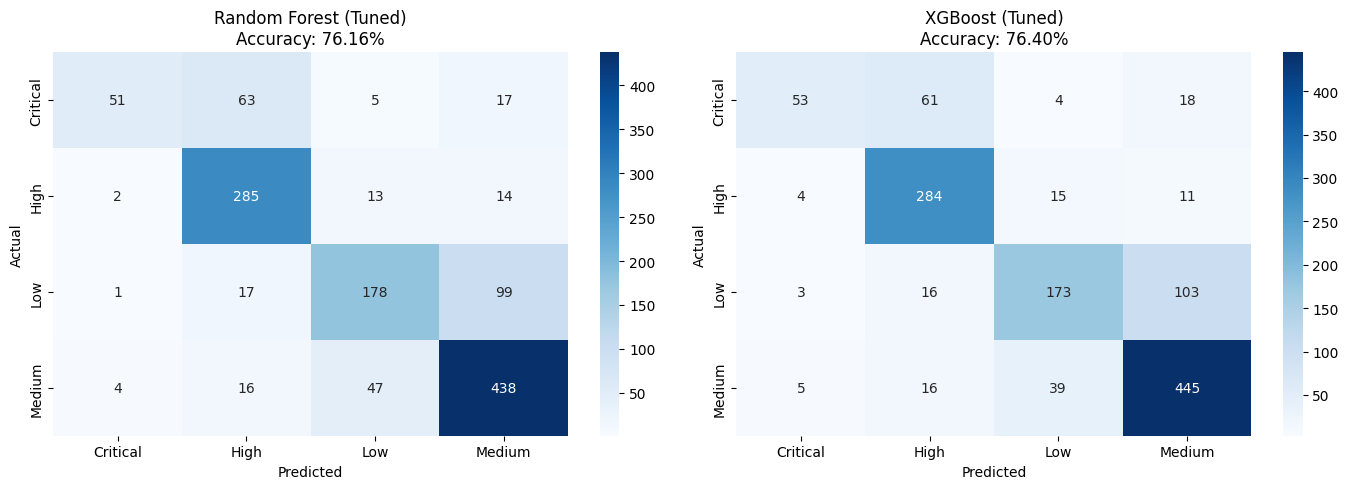

 Saved: priority_confusion_matrices.png


In [ ]:
# lets visualize results
# confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, pred, title, acc in zip(
    axes,
    [rf_tuned_pred, xgb_tuned_pred],
    ['Random Forest (Tuned)', 'XGBoost (Tuned)'],
    [rf_tuned_acc, xgb_tuned_acc]
):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=priority_encoder.classes_,
        yticklabels=priority_encoder.classes_,
        ax=ax
    )
    ax.set_title(f'{title}\nAccuracy: {acc*100:.2f}%')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('priority_confusion_matrices.png', dpi=150)
plt.show()
print(" Saved: priority_confusion_matrices.png")

## Integrate word load balancing using hybrid approach

In [ ]:
class WorkloadBalancer:
    def __init__(self, team_members, max_hours_per_week=40):
        self.team_members = team_members
        self.max_hours = max_hours_per_week
        self.workload = {
            member: {
                'tasks': [],
                'hours': 0,
                'skills': [],
                'efficiency': 1.0
            }
            for member in team_members
        }
    
    def set_member_skills(self, member, skills, efficiency=1.0):
        """Set skills and efficiency for a team member."""
        if member in self.workload:
            self.workload[member]['skills'] = skills
            self.workload[member]['efficiency'] = efficiency
    
    def get_available_capacity(self, member):
        """Get remaining available hours."""
        return self.max_hours - self.workload[member]['hours']
    
    def get_load_percentage(self, member):
        """Get current workload as percentage."""
        return (self.workload[member]['hours'] / self.max_hours) * 100
    
    def calculate_assignment_score(self, member, task):
        score = 0
        
        # factor 1
        available = self.get_available_capacity(member)
        capacity_ratio = available / self.max_hours
        score += capacity_ratio * 40
        
        # factor 2
        task_category = task.get('category', '')
        member_skills = self.workload[member]['skills']
        if task_category in member_skills:
            score += 30
        elif any(skill in task_category for skill in member_skills):
            score += 15 
        
        # factor 3
        priority_scores = {'Critical': 20, 'High': 15, 'Medium': 10, 'Low': 5}
        task_priority = task.get('priority', 'Medium')
        efficiency = self.workload[member]['efficiency']
        
        if task_priority in ['Critical', 'High'] and efficiency >= 1.0:
            score += priority_scores.get(task_priority, 10)
        else:
            score += priority_scores.get(task_priority, 10) * 0.5
        
        # factor 4: Load Balancing 
        all_loads = [self.get_load_percentage(m) for m in self.team_members]
        avg_load = np.mean(all_loads)
        member_load = self.get_load_percentage(member)
        
        if member_load <= avg_load:
            score += 10
        elif member_load <= avg_load * 1.2:
            score += 5
        
        return score
    
    def assign_task(self, task):
        """Assign single task to best available member."""
        task_hours = task.get('estimated_hours', 4)

In [ ]:
def assign_task(self, task):
    """Assign single task to best available member."""
    task_hours = task.get('estimated_hours', 4)
    
    # Find eligible members
    scores = {}
    for member in self.team_members:
        if self.get_available_capacity(member) >= task_hours:
            scores[member] = self.calculate_assignment_score(member, task)
    
    if not scores:
        return None, "No available member"
    
    # Select best member
    best_member = max(scores, key=scores.get)
    
    # Assign task
    self.workload[best_member]['tasks'].append(task)
    self.workload[best_member]['hours'] += task_hours
    
    return best_member, scores[best_member]

def assign_tasks_batch(self, tasks):
    """
    Assign multiple tasks with priority-based ordering.
    Critical/High priority tasks assigned first.
    """
    # Sort by priority
    priority_order = {'Critical': 0, 'High': 1, 'Medium': 2, 'Low': 3}
    sorted_tasks = sorted(
        tasks,
        key=lambda x: priority_order.get(x.get('priority', 'Medium'), 2)
    )
    
    assignments = []
    for task in sorted_tasks:
        member, score = self.assign_task(task)
        assignments.append({
            'task_id': task.get('task_id', 'N/A'),
            'category': task.get('category', 'N/A'),
            'priority': task.get('priority', 'N/A'),
            'hours': task.get('estimated_hours', 0),
            'assigned_to': member if member else 'UNASSIGNED',
            'score': f"{score:.1f}" if isinstance(score, float) else score
        })
    
    return pd.DataFrame(assignments)

def get_workload_summary(self):
    """Get summary of team workload distribution."""
    summary = []
    for member in self.team_members:
        data = self.workload[member]
        summary.append({
            'Member': member,
            'Tasks': len(data['tasks']),
            'Hours': data['hours'],
            'Capacity': f"{self.get_load_percentage(member):.1f}%",
            'Available': f"{self.get_available_capacity(member):.1f}h",
            'Skills': ', '.join(data['skills'][:3])
        })
    return pd.DataFrame(summary)

def get_workload_visualization_data(self):
    """Get data for visualization."""
    return {
        member: self.workload[member]['hours']
        for member in self.team_members
    }

def reset(self):
    """Reset all workloads."""
    for member in self.team_members:
        self.workload[member]['tasks'] = []
        self.workload[member]['hours'] = 0

In [ ]:
# visualize
team = ['Alice', 'Bob', 'Charlie', 'Diana', 'Eve']
balancer = WorkloadBalancer(team, max_hours_per_week=40)

# Set skills
balancer.set_member_skills('Alice', ['Development', 'Testing'], efficiency=1.2)
balancer.set_member_skills('Bob', ['Design', 'Documentation'], efficiency=1.0)
balancer.set_member_skills('Charlie', ['Research', 'Development'], efficiency=1.1)
balancer.set_member_skills('Diana', ['Testing', 'Documentation'], efficiency=0.9)
balancer.set_member_skills('Eve', ['Meeting', 'Design', 'Research'], efficiency=1.0)

print("Team configured with skills and efficiency ratings.\n")

# Load tasks from dataset
df_tasks = pd.read_csv('priority_dataset_10pct_noise.csv')
sample_tasks = df_tasks.head(30).to_dict('records')

print(f"Assigning {len(sample_tasks)} tasks\n")

# Assign tasks
assignments = balancer.assign_tasks_batch(sample_tasks)
print(assignments.to_string(index=False))
print(balancer.get_workload_summary().to_string(index=False))

Team configured with skills and efficiency ratings.

Assigning 30 tasks

   task_id      category priority  hours assigned_to score
TASK-00001 Documentation Critical      6         Bob 100.0
TASK-00014      Research Critical      9     Charlie 100.0
TASK-00012       Testing     High      7       Alice  95.0
TASK-00015   Development     High      7       Alice  78.0
TASK-00016   Development     High     15     Charlie  76.0
TASK-00019   Development     High      8       Alice  71.0
TASK-00020      Research     High      9         Eve  95.0
TASK-00024       Meeting     High      7         Eve  86.0
TASK-00027 Documentation     High      8         Bob  89.0
TASK-00002 Documentation   Medium      8       Diana  85.0
TASK-00005       Testing   Medium      7       Diana  77.0
TASK-00007       Meeting   Medium      3         Eve  69.0
TASK-00008       Testing   Medium      8       Diana  70.0
TASK-00009   Development   Medium      3       Alice  58.0
TASK-00010        Design   Medium      7  

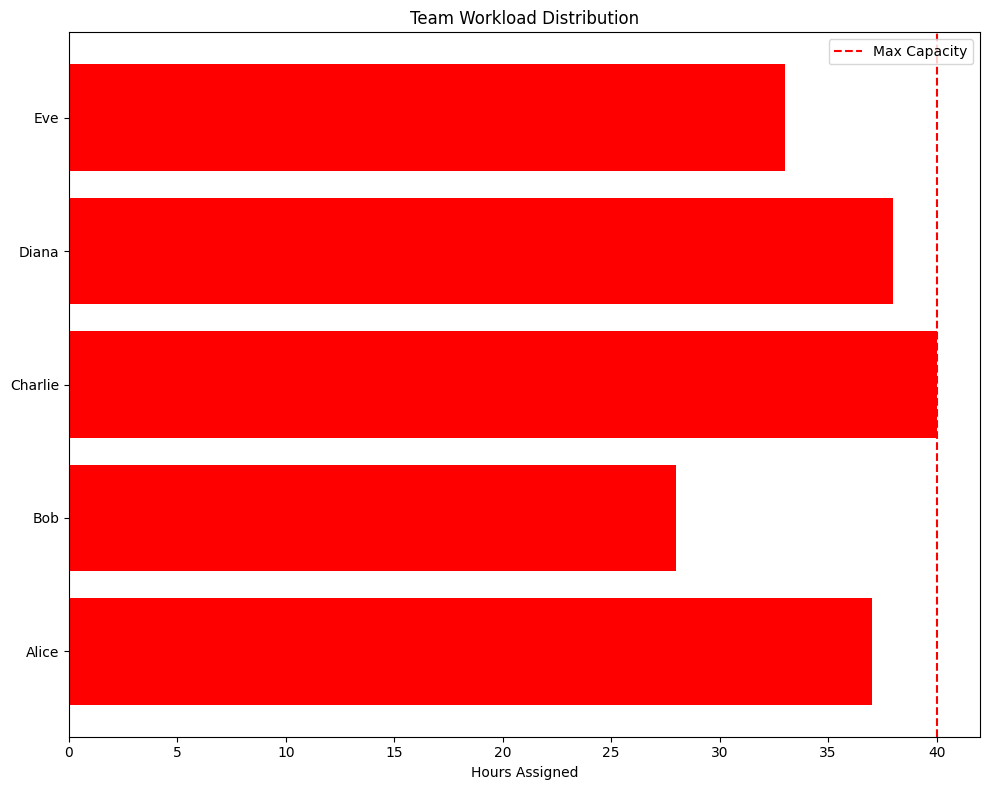

In [ ]:
summary = balancer.get_workload_summary()
colors = ['green' if float(c.strip('%')) < 70 else 'red' for c in summary['Capacity']]

plt.figure(figsize=(10, 8))
plt.barh(summary['Member'], summary['Hours'], color=colors)
plt.axvline(x=40, color='red', linestyle='--', label='Max Capacity')
plt.xlabel('Hours Assigned')
plt.title('Team Workload Distribution')
plt.legend()
plt.tight_layout()
plt.savefig('workload_horizontal.png')
plt.show()

# Dashboard and results

In [ ]:
# Category Classification Models
nb_model = joblib.load('naive_bayes_model.pkl')
svm_model = joblib.load('svm_model.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')
category_encoder = joblib.load('category_labels.pkl')

# Priority Prediction Models
rf_model = joblib.load('rf_priority_model.pkl')
xgb_model = joblib.load('xgb_priority_model.pkl')
priority_scaler = joblib.load('priority_scaler.pkl')
priority_encoder = joblib.load('priority_target_encoder.pkl')
priority_label_encoders = joblib.load('priority_label_encoders.pkl')
feature_cols = joblib.load('priority_feature_cols.pkl')

In [ ]:
metrics = { 
    'Category Classification': {
        'Naive Bayes': {'accuracy': 0.886, 'precision': 0.98, 'recall': 0.95, 'f1': 0.96},
        'SVM': {'accuracy': 0.896, 'precision': 1.00, 'recall': 0.99, 'f1': 1.00}
    },
    'Priority Prediction': {
        'Random Forest': {'accuracy': 76.16, 'precision': 76.0, 'recall': 75.0, 'f1': 75.5},
        'XGBoost': {'accuracy': 76.40, 'precision': 76.5, 'recall': 76.4, 'f1': 76.4}
    }
}
fig = plt.figure(figsize=(20, 20))
fig.suptitle(' AI-Powered Task Management System\nPerformance Dashboard', 
             fontsize=22, fontweight='bold', y=0.98)

Text(0.5, 0.98, '🤖 AI-Powered Task Management System\nPerformance Dashboard')

<Figure size 2000x2000 with 0 Axes>

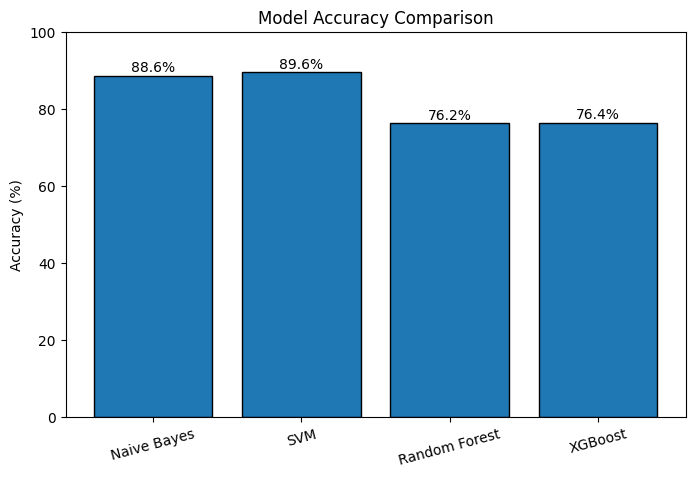

In [ ]:
models = ['Naive Bayes', 'SVM', 'Random Forest', 'XGBoost']
accuracies = [88.6, 89.6, 76.16, 76.40] 

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, edgecolor='black')

# Labels and title
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')

# Display values on top of bars
for bar, value in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, value + 1,
             f"{value:.1f}%", ha='center', fontsize=10)

# Formatting
plt.ylim(0, 100)
plt.xticks(rotation=15)

plt.show()


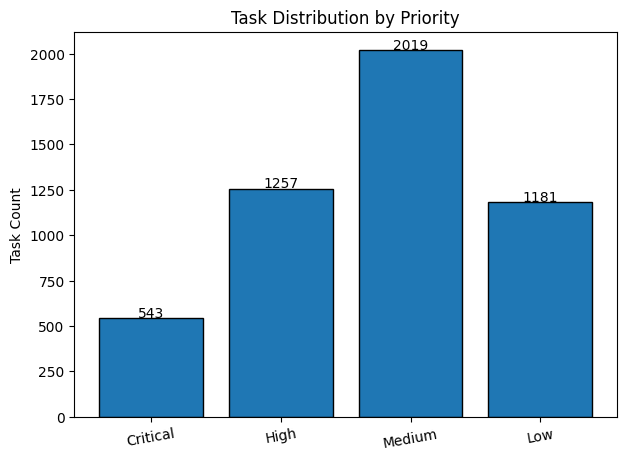

In [ ]:
# Load dataset
df = pd.read_csv('priority_dataset_10pct_noise.csv')

# Count values in order
priority_order = ['Critical', 'High', 'Medium', 'Low']
priority_counts = df['priority'].value_counts().reindex(priority_order)

# Plot
plt.figure(figsize=(7, 5))
bars = plt.bar(priority_counts.index, priority_counts.values, edgecolor='black')

# Labels and title
plt.ylabel("Task Count")
plt.title("Task Distribution by Priority")

# Display values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5,
             str(int(height)), ha='center', fontsize=10)

plt.xticks(rotation=10)
plt.show()
